# Load and visualize airspace volumes of French RTBA (Réseau très basse altitude défense)

### Information about RTBA here: https://www.sia.aviation-civile.gouv.fr/pub/media/news/file/p/l/plaquettertba_version_web_pap.pdf

In [1]:
%load_ext lab_black

In [2]:
from shapely.geometry import Polygon
import pandas as pd
from geopandas import GeoDataFrame
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

### Download list of RTBA airspace AIP names from SIA eAIP ENR5.1 (see "carte du réseau très basse altitude défense 2022")

In [3]:
names = pd.read_csv("rtba.csv", header=None, names=["aip_name"])
rtba_names = list(names.aip_name.values)

### Download RTBA airspace data from SIA UAS geographical zones data

In [4]:
json_file_path = (
    "UASZones_2022-07-14_20220629.json"  # to be updated with latest AIRAC cycle
)

### Build RTBA geodataframe 

In [5]:
df = pd.read_json(json_file_path, encoding="utf-8-sig")
features = (
    pd.DataFrame.from_dict(df.features.to_dict(), orient="index")
    .query("country == 'FXX'")
    .query("otherReasonInfo == 'Zone réglementée'")
    .rename(columns={"geometry": "g"})
)
features["aip_name"] = features.name.apply(lambda x: x.split("]")[1][1:])
features = features.query("aip_name in @rtba_names")
features["geometry"] = features.g.apply(
    lambda x: Polygon(x[0]["horizontalProjection"]["coordinates"][0])
)
features["lowerVerticalReference"] = features.g.apply(
    lambda x: x[0]["lowerVerticalReference"]
)
features["upperVerticalReference"] = features.g.apply(
    lambda x: x[0]["upperVerticalReference"]
)
features["lowerLimit"] = features.g.apply(lambda x: x[0]["lowerLimit"])
features["upperLimit"] = features.g.apply(lambda x: x[0]["upperLimit"])
features["reason"] = features.reason.apply(lambda x: " ".join(x))
features = features[
    [
        "aip_name",
        "name",
        "geometry",
        "lowerLimit",
        "lowerVerticalReference",
        "upperLimit",
        "upperVerticalReference",
        "otherReasonInfo",
        "reason",
    ]
].reset_index(drop=True)
rtba = GeoDataFrame(features, crs="EPSG:4326")  # WGS 84
rtba.head()

,aip_name,name,geometry,lowerLimit,lowerVerticalReference,upperLimit,upperVerticalReference,otherReasonInfo,reason
0,R 45 A,[LF][R 45 A] BOURGOGNE,"POLYGON ((5.20000 47.87444, 4.91583 47.82028, ...",0.00,AGL,243.84,AGL,Zone réglementée,OTHER
1,R 45 B,[LF][R 45 B] AUTUNOIS,"POLYGON ((3.99528 47.48806, 3.61250 47.32167, ...",0.00,AGL,243.84,AGL,Zone réglementée,OTHER
2,R 45 C,[LF][R 45 C] ARBOIS,"POLYGON ((5.92639 47.13444, 5.79194 47.05417, ...",0.00,AGL,243.84,AGL,Zone réglementée,OTHER
3,R 45 D,[LF][R 45 D] DOUBS,"POLYGON ((6.41361 47.69500, 5.72278 47.37111, ...",0.00,AGL,243.84,AGL,Zone réglementée,OTHER
4,R 45 N2,[LF][R 45 N2] ARDENNES,"POLYGON ((4.69500 49.57472, 4.58611 49.47778, ...",243.84,AGL,731.53,AGL,Zone réglementée,OTHER


### Save geodataframe as GeoJSON file

In [6]:
rtba.to_file("rtba.geojson", driver="GeoJSON")

D:\tdubot\anaconda3\envs\env2\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Load GeoJSON file and visualize RTBA on France map

In [7]:
gdf = gpd.read_file("rtba.geojson")
gdf.head()

,aip_name,name,lowerLimit,lowerVerticalReference,upperLimit,upperVerticalReference,otherReasonInfo,reason,geometry
0,R 45 A,[LF][R 45 A] BOURGOGNE,0.00,AGL,243.84,AGL,Zone réglementée,OTHER,"POLYGON ((5.20000 47.87444, 4.91583 47.82028, ..."
1,R 45 B,[LF][R 45 B] AUTUNOIS,0.00,AGL,243.84,AGL,Zone réglementée,OTHER,"POLYGON ((3.99528 47.48806, 3.61250 47.32167, ..."
2,R 45 C,[LF][R 45 C] ARBOIS,0.00,AGL,243.84,AGL,Zone réglementée,OTHER,"POLYGON ((5.92639 47.13444, 5.79194 47.05417, ..."
3,R 45 D,[LF][R 45 D] DOUBS,0.00,AGL,243.84,AGL,Zone réglementée,OTHER,"POLYGON ((6.41361 47.69500, 5.72278 47.37111, ..."
4,R 45 N2,[LF][R 45 N2] ARDENNES,243.84,AGL,731.53,AGL,Zone réglementée,OTHER,"POLYGON ((4.69500 49.57472, 4.58611 49.47778, ..."


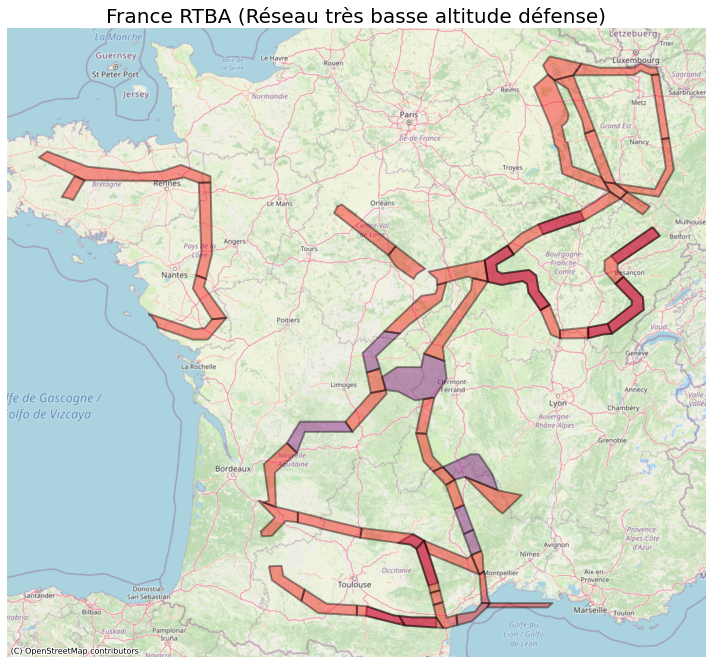

In [9]:
f, ax = plt.subplots(figsize=(10, 12))

gdf.to_crs(epsg=3857).query("lowerLimit == 0.0").plot(
    ax=ax,
    color="purple",
    linewidth=2.0,
    edgecolor="black",
    alpha=0.4,
)
gdf.to_crs(epsg=3857).query("lowerLimit > 0.0").plot(
    ax=ax,
    color="red",
    linewidth=2.0,
    edgecolor="black",
    alpha=0.4,
)
ctx.add_basemap(
    ax, zoom=7, source=ctx.providers.OpenStreetMap.Mapnik
)  # , zoom=8, source=ctx.providers.Stamen.TonerLite, alpha=1.0)
ax.axis("off")
ax.set_title("France RTBA (Réseau très basse altitude défense)", fontsize=20)
plt.tight_layout()
plt.savefig("rtba.jpg", dpi=300)

### Visualize RTBA (interactive map)

In [10]:
tooltip = [
    "name",
    "otherReasonInfo",
    "reason",
    "lowerLimit",
    "lowerVerticalReference",
    "upperLimit",
    "upperVerticalReference",
]
m = gdf.query("lowerLimit == 0.0").explore(
    color="mediumslateblue",
    tooltip=tooltip,
    style_kwds={"color": "black", "fillOpacity": 0.4},
)
gdf.query("lowerLimit > 0.0").explore(
    m=m,
    color="red",
    tooltip=tooltip,
    style_kwds={"color": "black", "fillOpacity": 0.4},
)
m